In [1]:
!pip install pyteomics pandas matplotlib transformers torch requests biopython tqdm uniprot-id-mapper


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# ==========================================
# Cell 1: Environment Setup
# ==========================================

import requests
import gzip
import pandas as pd
import numpy as np
from pyteomics import mzid
import matplotlib.pyplot as plt
import json
import os
import torch
import time
from tqdm.auto import tqdm
from Bio.Blast import NCBIWWW, NCBIXML
from io import StringIO
import logging


from transformers import AutoTokenizer, AutoModelForSequenceClassification
from google.colab import drive

drive.mount('/content/drive')

PROJECT_ROOT = '/content/drive/MyDrive/protein_classification'
MODELS_DIR = f'{PROJECT_ROOT}/models'
PRIDE_DATA_PATH = f'{PROJECT_ROOT}/data/merged.results.F115714.mzid.gz'

print("Environment setup complete")

Mounted at /content/drive
Environment setup complete


In [3]:
# ==========================================
# Cell 2: Data Loading and Preprocessing
# ==========================================

def load_pride_data_from_gz(file_path):
    """Load and parse PRIDE data from mzid.gz file, adapting new code's file handling."""
    print(f"Loading PRIDE data from: {file_path}")

    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        print("Please download from: https://ftp.pride.ebi.ac.uk/pride/data/archive/2018/12/PXD011467/")
        # Attempt to download if not found, mirroring the old code's initial download step
        url = "https://ftp.pride.ebi.ac.uk/pride/data/archive/2018/12/PXD011467/merged.results.F115714.mzid.gz"
        print(f"Attempting to download data from {url}")
        response = requests.get(url)
        if response.status_code == 200:
            with open(file_path, "wb") as f:
                f.write(response.content)
            print("Download successful.")
        else:
            print(f"Failed to download data. Status code: {response.status_code}")
            return None


    try:
        # Extract and parse mzid file (retaining old code's intermediate unzipping)
        filename_gz = file_path # Use the full path for .gz
        filename_mzid = "merged.results.F115714.mzid" # Keep consistent intermediate name

        with gzip.open(filename_gz, "rb") as f_in:
            with open(filename_mzid, "wb") as f_out:
                f_out.write(f_in.read())
        print(f"Decompressed {filename_gz} to {filename_mzid}")

        # Parse peptide data (from old code)
        with mzid.read(filename_mzid) as reader:
            peptides = [item for item in reader]

        psms = []
        for peptide in peptides:
            for psm in peptide["SpectrumIdentificationItem"]:
                peptide_seq = psm.get("PeptideSequence")
                modifications = psm.get("Modification", [])

                psms.append([
                    psm["PeptideEvidenceRef"][0]["start"],
                    psm["PeptideEvidenceRef"][0]["end"],
                    peptide_seq,
                    len(peptide_seq) if peptide_seq else None,
                    len(modifications),
                    psm["calculatedMassToCharge"],
                    psm["experimentalMassToCharge"],
                    psm["chargeState"],
                    psm.get("Mascot:score", None),
                    psm.get("percolator:Q value", None),
                    psm.get("percolator:PEP", None)
                ])
        # parse data and build a df of peptide
        df_psms = pd.DataFrame(psms, columns=["Start", "End", "Peptide", "Peptide_Length", "Num_Modifications", "Calculated_MZ", "Experimental_MZ", "Charge", "Mascot_Score", "Percolator_Q_Value", "Percolator_PEP"])
        print(f"Loaded {len(df_psms)} PSMs.")
        return df_psms

    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Load data (using the modified function)
df_psms = load_pride_data_from_gz(PRIDE_DATA_PATH)

if df_psms is not None:
    print(f"Data summary:")
    print(df_psms.head())

Loading PRIDE data from: /content/drive/MyDrive/protein_classification/data/merged.results.F115714.mzid.gz
Decompressed /content/drive/MyDrive/protein_classification/data/merged.results.F115714.mzid.gz to merged.results.F115714.mzid
Loaded 22341 PSMs.
Data summary:
   Start  End  Peptide  Peptide_Length  Num_Modifications  Calculated_MZ  \
0    612  618  AGSDGAR               7                  1     469.253850   
1    698  704  VGGALAR               7                  1     474.300604   
2    736  742  AMAELAA               7                  1     490.773015   
3    681  687  NVIIGPA               7                  1     494.310636   
4    681  687  NVIIGPA               7                  1     494.310636   

   Experimental_MZ  Charge  Mascot_Score  Percolator_Q_Value  Percolator_PEP  
0         469.2523       2         23.26            0.001254        0.004724  
1         474.3000       2         19.11            0.002278        0.012286  
2         490.7719       2         22.89

Combined figure saved in PLOS-compliant formats:
TIFF: /content/drive/MyDrive/protein_classification/final_analysis/proteomics_analysis_combined.tif
EPS: /content/drive/MyDrive/protein_classification/final_analysis/proteomics_analysis_combined.eps
PNG: /content/drive/MyDrive/protein_classification/final_analysis/proteomics_analysis_combined.png


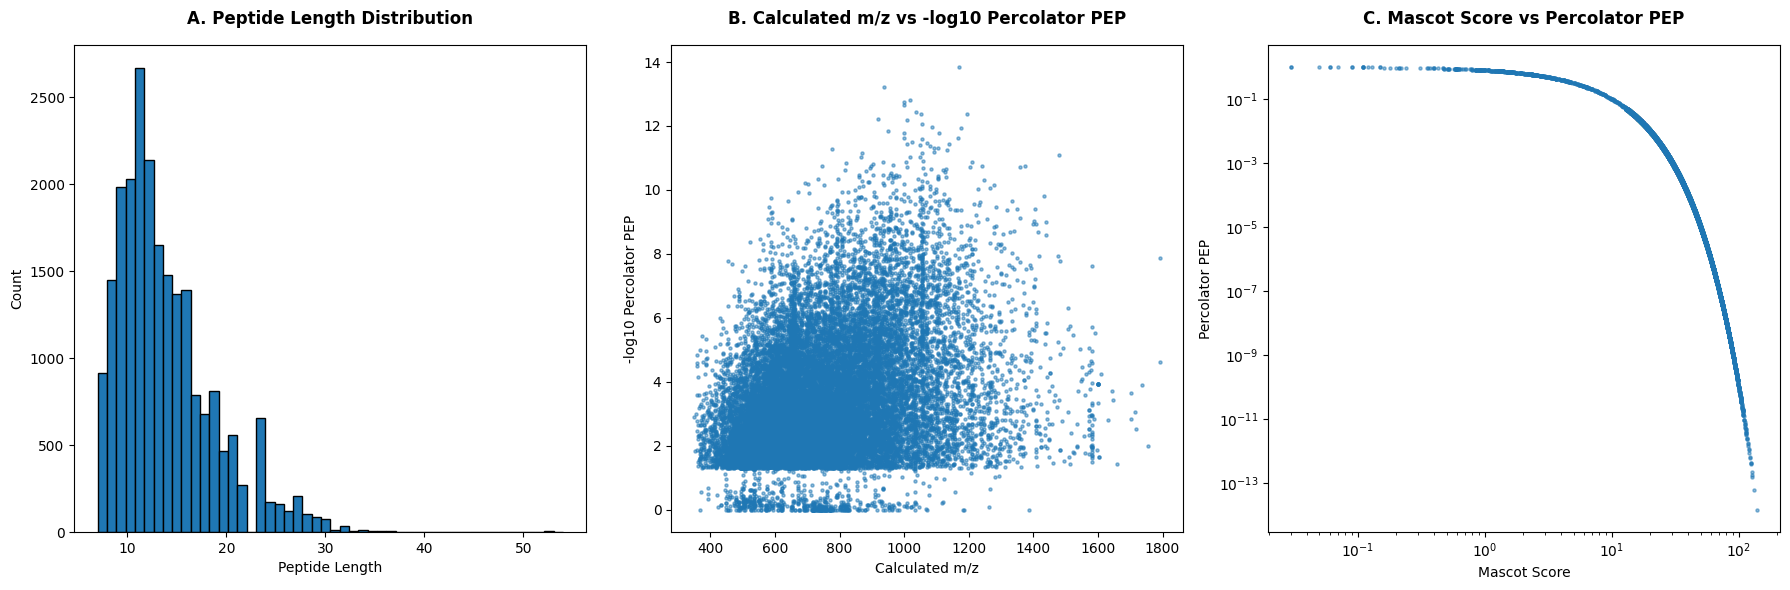

In [8]:
# ==========================================
# Cell 3: Visualization with ABC Labels
# ==========================================
import os
# Create final_analysis directory using PROJECT_ROOT path structure
final_analysis_dir = os.path.join(PROJECT_ROOT, 'final_analysis')
os.makedirs(final_analysis_dir, exist_ok=True)
if df_psms is not None:
    # Create a figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    # Plot A: Peptide Length Distribution
    axes[0].hist(df_psms["Peptide_Length"], bins=50, edgecolor='black')
    axes[0].set_xlabel("Peptide Length")
    axes[0].set_ylabel("Count")
    axes[0].set_title("A. Peptide Length Distribution", fontweight='bold', pad=15)
    # Plot B: m/z vs Percolator PEP
    axes[1].scatter(df_psms["Calculated_MZ"], -np.log10(df_psms["Percolator_PEP"]),
                   s=5, alpha=0.5)
    axes[1].set_xlabel("Calculated m/z")
    axes[1].set_ylabel("-log10 Percolator PEP")
    axes[1].set_title("B. Calculated m/z vs -log10 Percolator PEP", fontweight='bold', pad=15)
    # Plot C: Mascot Score vs Percolator PEP
    axes[2].scatter(df_psms["Mascot_Score"], df_psms["Percolator_PEP"],
                   s=5, alpha=0.5)
    axes[2].set_xlabel("Mascot Score")
    axes[2].set_ylabel("Percolator PEP")
    axes[2].set_title("C. Mascot Score vs Percolator PEP", fontweight='bold', pad=15)
    axes[2].set_xscale('log')
    axes[2].set_yscale('log')
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)

    # Save in PLOS-compliant formats
    base_path = os.path.join(final_analysis_dir, 'proteomics_analysis_combined')

    # TIFF with LZW compression
    plt.savefig(f'{base_path}.tif', dpi=300, bbox_inches='tight', facecolor='white',
                format='tiff', pil_kwargs={'compression': 'tiff_lzw'})

    # EPS format
    plt.savefig(f'{base_path}.eps', dpi=300, bbox_inches='tight', facecolor='white')

    # PNG for preview
    plt.savefig(f'{base_path}.png', dpi=300, bbox_inches='tight', facecolor='white')

    print(f"Combined figure saved in PLOS-compliant formats:")
    print(f"TIFF: {base_path}.tif")
    print(f"EPS: {base_path}.eps")
    print(f"PNG: {base_path}.png")

    plt.show()
else:
    print("Warning: df_psms is None. Please ensure the data is loaded correctly.")

In [ ]:
# ==========================================
# Cell 4: Model Loading and Prediction
# ==========================================

from tqdm.auto import tqdm # Import tqdm

tqdm.pandas()

def load_esm_model_new():
    """Load fine-tuned ESM-2 model for ECM prediction using new code's method"""
    model_path = f"{MODELS_DIR}/esm2_ecm_model_enhanced"

    if not os.path.exists(model_path):
        print(f"Error: Model not found at {model_path}")
        print("Please ensure the model is saved in the correct location on Google Drive")
        return None, None

    print(f"Loading model from: {model_path}")

    try:
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForSequenceClassification.from_pretrained(model_path)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        model.eval()

        print(f"Model loaded successfully on {device}")
        return model, tokenizer

    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None

def predict_functions_new(sequence, model, tokenizer):
    """Predict ECM probability for a peptide sequence using new code's method"""
    if not isinstance(sequence, str) or not sequence.strip():
        return np.nan

    try:
        device = next(model.parameters()).device
        inputs = tokenizer(
            sequence,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=1024
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        probs = torch.softmax(outputs.logits, dim=-1)
        return probs[0][1].cpu().item()

    except Exception as e:
        return 0.0

# Load model and run predictions
model, tokenizer = load_esm_model_new()

if model is not None and tokenizer is not None:
    print("Running ESM predictions...")
    df_psms['esm_result'] = df_psms['Peptide'].progress_apply(
        lambda x: predict_functions_new(x, model, tokenizer)
    )

    df_psms = df_psms.dropna(subset=['esm_result'])

    print("Predictions complete")
    print(df_psms.head())

    # Use the optimal threshold (0.168) found during model comparison for high-confidence peptides
    optimal_threshold_for_pride = 0.168
    high_psms = df_psms[df_psms['esm_result'] > optimal_threshold_for_pride]
    print(f"\nHigh scoring PSMs (esm_result > {optimal_threshold_for_pride}):")

    print(high_psms.head())
else:
    print("Model not loaded, skipping ESM predictions and subsequent steps.")
    df_psms = None

# save
esm_output_path = os.path.join(PROJECT_ROOT, "final_analysis", "all_psms_with_esm_result.csv")
df_psms.to_csv(esm_output_path, index=False)
print(f"\n Saved full PSM predictions to: {esm_output_path}")

high_output_path = os.path.join(PROJECT_ROOT, "final_analysis", "high_confidence_psms.csv")
high_psms.to_csv(high_output_path, index=False)
print(f" Saved high-scoring PSMs to: {high_output_path}")


Loading model from: /content/drive/MyDrive/protein_classification/models/esm2_ecm_model_enhanced
Model loaded successfully on cuda


In [ ]:
# run predictions

if model is not None and tokenizer is not None:
    print("Running ESM predictions...")
    df_psms['esm_result'] = df_psms['Peptide'].progress_apply(
        lambda x: predict_functions_new(x, model, tokenizer)
    )

    df_psms = df_psms.dropna(subset=['esm_result'])

    print("Predictions complete")
    print(df_psms.head())

    # Use the optimal threshold (0.168) found during model comparison for high-confidence peptides
    optimal_threshold_for_pride = 0.168
    high_psms = df_psms[df_psms['esm_result'] > optimal_threshold_for_pride]
    print(f"\nHigh scoring PSMs (esm_result > {optimal_threshold_for_pride}):")

    print(high_psms.head())
else:
    print("Model not loaded, skipping ESM predictions and subsequent steps.")
    df_psms = None

# save
esm_output_path = os.path.join(PROJECT_ROOT, "final_analysis", "all_psms_with_esm_result.csv")
df_psms.to_csv(esm_output_path, index=False)
print(f"\n Saved full PSM predictions to: {esm_output_path}")

high_output_path = os.path.join(PROJECT_ROOT, "final_analysis", "high_confidence_psms.csv")
high_psms.to_csv(high_output_path, index=False)
print(f" Saved high-scoring PSMs to: {high_output_path}")

Running ESM predictions...


  0%|          | 0/22341 [00:00<?, ?it/s]

Predictions complete
   Start  End  Peptide  Peptide_Length  Num_Modifications  Calculated_MZ  \
0    612  618  AGSDGAR               7                  1     469.253850   
1    698  704  VGGALAR               7                  1     474.300604   
2    736  742  AMAELAA               7                  1     490.773015   
3    681  687  NVIIGPA               7                  1     494.310636   
4    681  687  NVIIGPA               7                  1     494.310636   

   Experimental_MZ  Charge  Mascot_Score  Percolator_Q_Value  Percolator_PEP  \
0         469.2523       2         23.26            0.001254        0.004724   
1         474.3000       2         19.11            0.002278        0.012286   
2         490.7719       2         22.89            0.001254        0.005138   
3         494.3081       2         40.47            0.000317        0.000090   
4         494.3085       2         21.21            0.001445        0.007574   

   esm_result  
0    0.000889  
1    0.00

In [ ]:
# ==========================================
# Cell 5: Peptide-Protein Mapping and Deduplication
# ==========================================

import xml.etree.ElementTree as ET
import gzip
import pandas as pd
import os
from collections import defaultdict

def extract_peptide_to_protein_map_rawxml(mzid_gz_path):
    print(f"Parsing raw XML from: {mzid_gz_path}")

    # Decompress and parse XML
    mzid_path = "temp_data.mzid"
    with gzip.open(mzid_gz_path, 'rb') as f_in, open(mzid_path, 'wb') as f_out:
        f_out.write(f_in.read())

    tree = ET.parse(mzid_path)
    root = tree.getroot()
    ns = {'ns': root.tag.split("}")[0].strip("{")}

    # Build mapping dictionaries
    pe2db = {pe.get('id'): pe.get('dBSequence_ref')
             for pe in root.findall('.//ns:PeptideEvidence', ns)
             if pe.get('id') and pe.get('dBSequence_ref')}

    db2acc = {db.get('id'): db.get('accession')
              for db in root.findall('.//ns:DBSequence', ns)
              if db.get('id') and db.get('accession')}

    peptide_ref_to_seq = {pep.get('id'): pep.find('ns:PeptideSequence', ns).text
                          for pep in root.findall('.//ns:Peptide', ns)
                          if pep.get('id') and pep.find('ns:PeptideSequence', ns) is not None}

    # Extract peptide-protein relationships
    pepseq_to_protein_ids = defaultdict(set)
    for sir in root.findall('.//ns:SpectrumIdentificationResult', ns):
        for sii in sir.findall('.//ns:SpectrumIdentificationItem', ns):
            pep_seq = peptide_ref_to_seq.get(sii.get('peptide_ref'))
            if pep_seq:
                for pe_ref_el in sii.findall('ns:PeptideEvidenceRef', ns):
                    pe_ref = pe_ref_el.get('peptideEvidence_ref')
                    acc = db2acc.get(pe2db.get(pe_ref))
                    if acc:
                        pepseq_to_protein_ids[pep_seq].add(acc)

    # Clean up temporary file
    os.remove(mzid_path)

    print(f"Extracted mapping for {len(pepseq_to_protein_ids)} peptides")
    return dict(pepseq_to_protein_ids)

def deduplicate_peptides(high_psms, peptide_protein_map):
    print(f"Deduplicating: {len(high_psms)} records -> {high_psms['Peptide'].nunique()} unique peptides")

    # Add protein IDs to dataframe
    high_psms = high_psms.copy()
    high_psms['Protein_IDs'] = high_psms['Peptide'].map(
        lambda pep: ";".join(sorted(peptide_protein_map.get(pep, [])))
    )

    # Group by peptide and keep best record with merged protein info
    dedup_records = []
    for peptide, group in high_psms.groupby('Peptide'):
        # Merge all protein IDs for this peptide
        all_proteins = set()
        for protein_str in group['Protein_IDs'].dropna():
            if protein_str:
                all_proteins.update(protein_str.split(';'))

        # Get record with highest E
        best_idx = group['epop_result'].idxmax()
        best_record = group.loc[best_idx].copy()

        # Update with merged protein info
        best_record['Protein_IDs'] = ";".join(sorted(all_proteins))
        best_record['Duplicate_Count'] = len(group)
        best_record['Protein_Count'] = len(all_proteins)

        dedup_records.append(best_record)

    deduplicated_df = pd.DataFrame(dedup_records)

    print(f"Result: {len(deduplicated_df)} unique peptides, avg {deduplicated_df['Protein_Count'].mean():.1f} proteins per peptide")

    # Show duplication stats
    dup_stats = deduplicated_df['Duplicate_Count'].value_counts().sort_index()
    print("Duplication stats:", dict(dup_stats.head()))

    return deduplicated_df

def analyze_protein_coverage(df):
    """Analyze protein coverage from deduplicated data"""
    print("\n=== Protein Coverage Analysis ===")

    # Count peptides per protein
    protein_counts = defaultdict(int)
    for _, row in df.iterrows():
        if row['Protein_IDs']:
            for protein_id in row['Protein_IDs'].split(';'):
                protein_counts[protein_id.strip()] += 1

    total_proteins = len(protein_counts)
    print(f"Total proteins involved: {total_proteins}")

    # Show top proteins by peptide count
    top_proteins = sorted(protein_counts.items(), key=lambda x: x[1], reverse=True)[:10]
    print("Top proteins by peptide count:")
    for i, (protein_id, count) in enumerate(top_proteins, 1):
        display_id = protein_id.split('.')[0]  # Remove version
        print(f"  {i:2d}. {display_id}: {count} peptides")

    return protein_counts

# Main execution
print("=== Starting Optimized Peptide-Protein Mapping ===")

# Extract peptide-protein mapping
mzid_map = extract_peptide_to_protein_map_rawxml(PRIDE_DATA_PATH)

# Deduplicate high confidence PSMs
deduplicated_high_psms = deduplicate_peptides(high_psms, mzid_map)

# Analyze protein coverage
protein_coverage = analyze_protein_coverage(deduplicated_high_psms)

# Preview results
print(f"\n=== Deduplicated Data Preview ===")
preview_cols = ['Peptide', 'esm_result', 'Protein_Count', 'Duplicate_Count']
print(deduplicated_high_psms[preview_cols].head())

# Save results
output_path = os.path.join(PROJECT_ROOT, "final_analysis", "deduplicated_high_confidence_psms.csv")
deduplicated_high_psms.to_csv(output_path, index=False)
print(f"\nSaved deduplicated data to: {output_path}")

# Update global variable for subsequent analysis
high_psms = deduplicated_high_psms
print(f"✓ Deduplication complete. Using {len(high_psms)} unique peptides for downstream analysis")

=== Starting Optimized Peptide-Protein Mapping ===
Parsing raw XML from: /content/drive/MyDrive/protein_classification/data/merged.results.F115714.mzid.gz
Extracted mapping for 8747 peptides
Deduplicating: 63 records -> 63 unique peptides
Result: 63 unique peptides, avg 2.4 proteins per peptide
Duplication stats: {1: np.int64(63)}

=== Protein Coverage Analysis ===
Total proteins involved: 110
Top proteins by peptide count:
   1. ENSP00000225964: 5 peptides
   2. ENSP00000295550: 3 peptides
   3. ENSP00000315609: 3 peptides
   4. ENSP00000315873: 3 peptides
   5. ENSP00000264613: 3 peptides
   6. ENSP00000420545: 3 peptides
   7. ENSP00000297268: 3 peptides
   8. ENSP00000355180: 2 peptides
   9. ENSP00000483630: 2 peptides
  10. ENSP00000416330: 2 peptides

=== Deduplicated Data Preview ===
                                     Peptide  esm_result  Protein_Count  \
0              AGLELGAEPETIVNSGLISPEGLAIDHIR    0.419397              2   
1  AIHVHQFGDLSQGCESTGPHYNPLAVPHPQHPGDFGNFAVR   

In [ ]:
# ====================================================
# Ensembl to UniProt Mapping
# ====================================================

import pandas as pd
import requests
import time
import os

# Configuration
PROJECT_ROOT = '/content/drive/MyDrive/protein_classification'

def batch_uniprot_mapping(ensembl_ids, batch_size=30):
    """Batch UniProt mapping to avoid API limits"""
    all_results = []

    for i in range(0, len(ensembl_ids), batch_size):
        batch = ensembl_ids[i:i + batch_size]
        batch_num = i//batch_size + 1
        total_batches = (len(ensembl_ids)-1)//batch_size + 1
        print(f"  Processing batch {batch_num}/{total_batches} ({len(batch)} IDs)")

        try:
            # Submit mapping job
            url = "https://rest.uniprot.org/idmapping/run"
            headers = {"Content-Type": "application/x-www-form-urlencoded"}
            params = {
                "from": "Ensembl_Protein",
                "to": "UniProtKB",
                "ids": ",".join(batch)
            }

            response = requests.post(url, data=params, headers=headers)
            if response.status_code != 200:
                print(f"    Batch failed: {response.text}")
                continue

            job_id = response.json()["jobId"]

            # Wait for completion
            status_url = f"https://rest.uniprot.org/idmapping/status/{job_id}"
            for _ in range(15):  # Max 30 seconds wait
                status = requests.get(status_url).json()
                if status.get("jobStatus") in [None, "FINISHED"]:
                    break
                time.sleep(2)

            # Get results
            result_url = f"https://rest.uniprot.org/idmapping/uniprotkb/results/{job_id}?format=tsv"
            batch_result = pd.read_csv(result_url, sep="\t")

            if len(batch_result) > 0:
                all_results.append(batch_result)
                print(f"    Successfully mapped: {len(batch_result)} IDs")
            else:
                print(f"    No mappings found for this batch")

            time.sleep(1)  # Avoid rate limiting

        except Exception as e:
            print(f"    Batch error: {e}")
            continue

    # Combine all results
    if all_results:
        return pd.concat(all_results, ignore_index=True)
    else:
        return pd.DataFrame()

def map_ensembl_to_uniprot(high_psms_df):
    """Main mapping function using deduplicated data"""

    print("=== Improved Ensembl to UniProt Mapping ===")

    # 1. Extract all unique protein IDs (with versions)
    all_protein_ids = set()
    for _, row in high_psms_df.iterrows():
        if pd.notna(row['Protein_IDs']):
            for prot_id in row['Protein_IDs'].split(';'):
                if prot_id.strip():
                    all_protein_ids.add(prot_id.strip())

    all_protein_ids = list(all_protein_ids)
    print(f"1. Extracted {len(all_protein_ids)} unique versioned Ensembl IDs")

    # 2. Batch mapping to UniProt
    print("2. Executing batch mapping...")
    mapping_result = batch_uniprot_mapping(all_protein_ids, batch_size=30)

    if len(mapping_result) == 0:
        print("No mapping results obtained!")
        return None, None

    print(f"3. Mapping statistics:")
    print(f"   Successfully mapped Ensembl IDs: {len(mapping_result)}")
    print(f"   Unique UniProt IDs: {mapping_result['Entry'].nunique()}")
    print(f"   Mapping success rate: {len(mapping_result)/len(all_protein_ids)*100:.1f}%")

    # 3. Create Ensembl to UniProt lookup dictionary
    ensembl_to_uniprot = {}
    for _, row in mapping_result.iterrows():
        ensembl_id = row['From']
        ensembl_to_uniprot[ensembl_id] = {
            'uniprot_id': row['Entry'],
            'protein_name': row.get('Protein names', ''),
            'gene_name': row.get('Gene Names', ''),
            'reviewed': row.get('Reviewed', ''),
            'length': row.get('Length', 0)
        }

    # 4. Create enhanced peptide dataset (only reviewed proteins)
    print("4. Creating enhanced peptide dataset...")
    enhanced_rows = []

    for _, row in high_psms_df.iterrows():
        base_row = row.to_dict()

        # Find UniProt matches for this peptide's proteins
        if pd.notna(row['Protein_IDs']):
            for prot_id in row['Protein_IDs'].split(';'):
                prot_id = prot_id.strip()
                if prot_id in ensembl_to_uniprot:
                    uniprot_info = ensembl_to_uniprot[prot_id]
                    # Only include reviewed proteins
                    if uniprot_info['reviewed'] == 'reviewed':
                        match_row = base_row.copy()
                        match_row.update({
                            'Ensembl_ID': prot_id,
                            'UniProt_ID': uniprot_info['uniprot_id'],
                            'Protein_Name': uniprot_info['protein_name'],
                            'Gene_Name': uniprot_info['gene_name'],
                            'UniProt_Reviewed': uniprot_info['reviewed'],
                            'Protein_Length': uniprot_info['length']
                        })
                        enhanced_rows.append(match_row)

    if not enhanced_rows:
        print("No enhanced rows created!")
        return None, mapping_result

    enhanced_df = pd.DataFrame(enhanced_rows)
    print(f"   Created {len(enhanced_df)} enhanced records from {len(enhanced_rows)} UniProt matches")

    # 5. Save results
    output_dir = os.path.join(PROJECT_ROOT, "final_analysis")

    # Save mapping results
    mapping_path = os.path.join(output_dir, "ensembl_uniprot_mapping.csv")
    mapping_result.to_csv(mapping_path, index=False)

    # Save enhanced peptide data
    enhanced_path = os.path.join(output_dir, "peptides_with_uniprot_info.csv")
    enhanced_df.to_csv(enhanced_path, index=False)

    print(f"5. Files saved:")
    print(f"   Mapping results: {mapping_path}")
    print(f"   Enhanced peptides: {enhanced_path}")

    return enhanced_df, mapping_result

# Execute mapping - load from existing file if available
print("Starting UniProt mapping process...")

# Try to load existing deduplicated data first
try:
    high_psms_path = os.path.join(PROJECT_ROOT, "final_analysis", "deduplicated_high_confidence_psms.csv")
    if os.path.exists(high_psms_path):
        print(f"Loading existing data from: {high_psms_path}")
        high_psms = pd.read_csv(high_psms_path)
        print(f"Loaded {len(high_psms)} deduplicated PSMs")
    else:
        print(" Deduplicated data file not found. Please run the deduplication step first.")
        print(f"Expected file: {high_psms_path}")
        high_psms = None
except Exception as e:
    print(f" Error loading data: {e}")
    high_psms = None

if high_psms is not None:
    enhanced_data, mapping_data = map_ensembl_to_uniprot(high_psms)

    if enhanced_data is not None:
        print(f"\n Mapping complete! Enhanced dataset contains {len(enhanced_data)} records")
        print(f"  Unique peptides with UniProt info: {enhanced_data['Peptide'].nunique()}")
        print(f"  Unique proteins identified: {enhanced_data['UniProt_ID'].nunique()}")
    else:
        print(" Mapping failed - please check the results above")
else:
    print(" Cannot proceed without input data")

Starting UniProt mapping process...
Loading existing data from: /content/drive/MyDrive/protein_classification/final_analysis/deduplicated_high_confidence_psms.csv
Loaded 63 deduplicated PSMs
=== Improved Ensembl to UniProt Mapping ===
1. Extracted 110 unique versioned Ensembl IDs
2. Executing batch mapping...
  Processing batch 1/4 (30 IDs)
    Successfully mapped: 25 IDs
  Processing batch 2/4 (30 IDs)
    Successfully mapped: 25 IDs
  Processing batch 3/4 (30 IDs)
    Successfully mapped: 25 IDs
  Processing batch 4/4 (20 IDs)
    Successfully mapped: 16 IDs
3. Mapping statistics:
   Successfully mapped Ensembl IDs: 91
   Unique UniProt IDs: 74
   Mapping success rate: 82.7%
4. Creating enhanced peptide dataset...
   Created 78 enhanced records from 78 UniProt matches
5. Files saved:
   Mapping results: /content/drive/MyDrive/protein_classification/final_analysis/ensembl_uniprot_mapping.csv
   Enhanced peptides: /content/drive/MyDrive/protein_classification/final_analysis/peptides_wi

In [ ]:
def build_final_protein_table(enhanced_df, save_path=None):
    """
    Build a final protein-level table with unique proteins and their characteristics
    All proteins are predicted as ECM-related by the EPOP model (99.4% accuracy)
    """
    print("\n=== Building Final Protein-Level Table ===")

    protein_records = {}

    for _, row in enhanced_df.iterrows():
        uid = row['UniProt_ID']

        if uid not in protein_records:
            protein_records[uid] = {
                'UniProt_ID': uid,
                'Gene_Name': row.get('Gene_Name', ''),
                'Protein_Name': row.get('Protein_Name', ''),
                'Reviewed': row.get('UniProt_Reviewed', ''),
                'Protein_Length': row.get('Protein_Length', 0),
                'Top_ESM_Score': row.get('esm_result', 0),
                'Num_Peptides': 1,
                'Peptides': [row.get('Peptide', '')],
                'ESM_Scores': [row.get('esm_result', 0)]
            }
        else:
            protein_records[uid]['Top_ESM_Score'] = max(
                protein_records[uid]['Top_ESM_Score'],
                row.get('esm_result', 0)
            )
            protein_records[uid]['Num_Peptides'] += 1
            protein_records[uid]['Peptides'].append(row.get('Peptide', ''))
            protein_records[uid]['ESM_Scores'].append(row.get('esm_result', 0))

    # Convert to DataFrame
    final_df = pd.DataFrame(protein_records.values())

    # Calculate average ESM score
    final_df['Avg_ESM_Score'] = final_df['ESM_Scores'].apply(lambda x: sum(x) / len(x))

    # Add peptide list
    final_df['Peptide_List'] = final_df['Peptides'].apply(lambda x: '; '.join(x))

    # Clean up temporary columns
    final_df.drop(['Peptides', 'ESM_Scores'], axis=1, inplace=True)

    # Sort by top ESM score
    final_df.sort_values("Top_ESM_Score", ascending=False, inplace=True)
    final_df.reset_index(drop=True, inplace=True)

    # Statistics
    print(f"Final protein table with {len(final_df)} unique proteins (all predicted as ECM-related)")
    print(f"All proteins are reviewed: {(final_df['Reviewed'] == 'reviewed').sum()}/{len(final_df)}")
    print(f"Average peptides per protein: {final_df['Num_Peptides'].mean():.1f}")
    print(f"ESM score range: {final_df['Top_ESM_Score'].min():.3f} - {final_df['Top_ESM_Score'].max():.3f}")

    # Show top proteins by ESM score
    print(f"\nTop 10 proteins by ESM score:")
    for i, (_, row) in enumerate(final_df.head(10).iterrows(), 1):
        gene_name = row['Gene_Name'] if row['Gene_Name'] else 'N/A'
        print(f"{i:2d}. {gene_name} ({row['UniProt_ID']}) - ESM: {row['Top_ESM_Score']:.3f}")

    # Save to file
    if save_path:
        final_df.to_csv(save_path, index=False)
        print(f"\nSaved to: {save_path}")

    return final_df

# Execute the function
final_protein_path = os.path.join(PROJECT_ROOT, "final_analysis", "final_unique_protein_table.csv")
final_protein_df = build_final_protein_table(enhanced_data, save_path=final_protein_path)

# Display results preview
print(f"\n=== Final Protein Table Preview ===")
display_columns = ['UniProt_ID', 'Gene_Name', 'Protein_Name', 'Top_ESM_Score', 'Avg_ESM_Score', 'Num_Peptides', 'Reviewed']
print(final_protein_df[display_columns].head(10))


=== Building Final Protein-Level Table ===
Final protein table with 40 unique proteins (all predicted as ECM-related)
All proteins are reviewed: 40/40
Average peptides per protein: 1.9
ESM score range: 0.174 - 0.997

Top 10 proteins by ESM score:
 1. COL6A1 (P12109) - ESM: 0.997
 2. COL1A2 (P08123) - ESM: 0.996
 3. COL6A3 (P12111) - ESM: 0.981
 4. COL4A2 (P08572) - ESM: 0.948
 5. VTN (P04004) - ESM: 0.851
 6. C3 CPAMD1 (P01024) - ESM: 0.744
 7. GUCY2C GUC2C STAR (P25092) - ESM: 0.743
 8. NCOA3 AIB1 BHLHE42 RAC3 TRAM1 (Q9Y6Q9) - ESM: 0.663
 9. POSTN OSF2 (Q15063) - ESM: 0.633
10. CFB BF BFD (P00751) - ESM: 0.626

Saved to: /content/drive/MyDrive/protein_classification/final_analysis/final_unique_protein_table.csv

=== Final Protein Table Preview ===
  UniProt_ID                      Gene_Name  \
0     P12109                         COL6A1   
1     P08123                         COL1A2   
2     P12111                         COL6A3   
3     P08572                         COL4A2   
4    

Starting EPOP validation analysis...
Extracted 40 unique genes from 40 proteins
Analyzing 40 genes via Enrichr...
  Querying GO_Biological_Process_2021...
    Found 47 significant terms
  Querying GO_Cellular_Component_2021...
    Found 20 significant terms
  Querying KEGG_2021_Human...
    Found 14 significant terms
  Querying Reactome_2022...
    Found 48 significant terms
  Querying WikiPathways_2019_Human...
    Found 19 significant terms

FUNCTIONAL ENRICHMENT ANALYSIS RESULTS
Analyzed 40 EPOP-identified proteins

GO BIOLOGICAL PROCESS 2021:
------------------------------------------------------------
★  1. extracellular matrix organization (GO:0030198)
      P-adj: 1.88e-18 | Genes: POSTN, CMA1, COL14A1, FGG (+13 more)
★  2. extracellular structure organization (GO:0043062)
      P-adj: 1.02e-17 | Genes: POSTN, COL14A1, FGG, FN1 (+11 more)
★  3. external encapsulating structure organization (GO:0045229)
      P-adj: 1.02e-17 | Genes: POSTN, COL14A1, FGG, FN1 (+11 more)
★  4. supr

Validation figure saved in PLOS-compliant formats:
TIFF: /content/drive/MyDrive/protein_classification/final_analysis/validation_figure.tif
EPS: /content/drive/MyDrive/protein_classification/final_analysis/validation_figure.eps
PNG: /content/drive/MyDrive/protein_classification/final_analysis/validation_figure.png


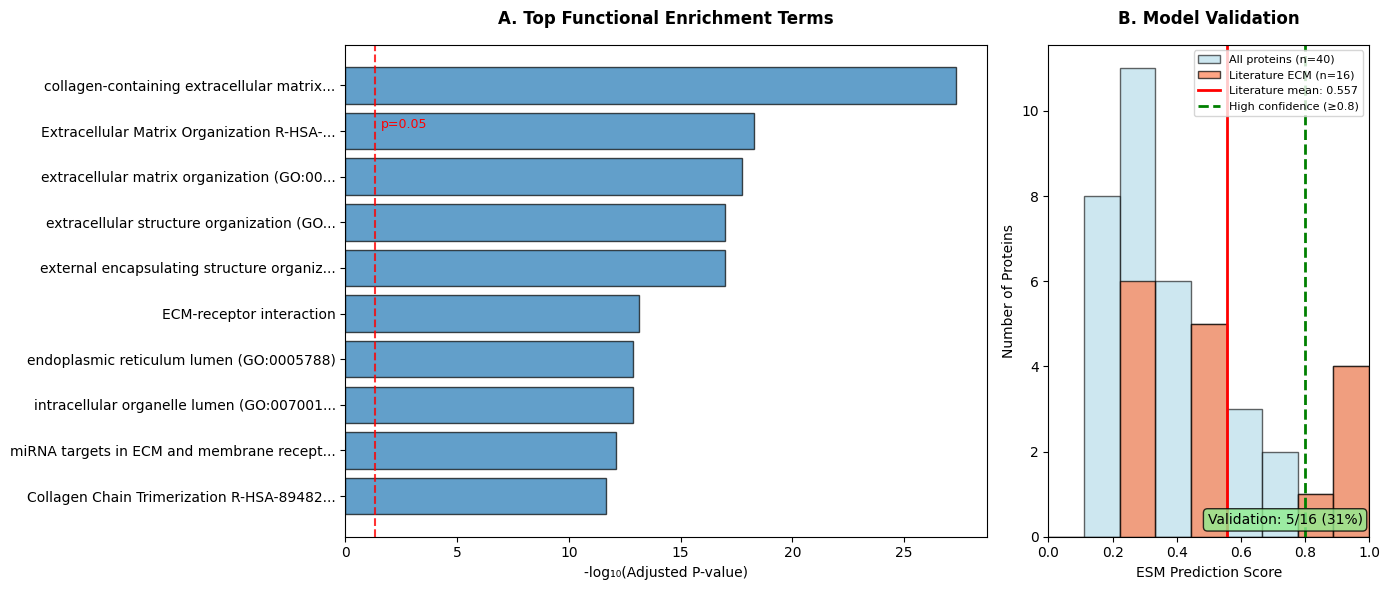

All results saved to final_analysis folder

EPOP validation complete!
Files: validation_figure.tif/.eps/.png, EPOP_VALIDATION_REPORT.txt, CSV files


In [25]:
# ====================================================
# Streamlined EPOP Validation Analysis
# ====================================================

import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import warnings
warnings.filterwarnings('ignore')

# Literature-supported ECM proteins (UniProt IDs)
LITERATURE_ECM_PROTEINS = [
    'Q99715', 'Q06828', 'Q05707', 'P22105', 'P12111', 'P12109',
    'P08123', 'Q15582', 'P02751', 'P02458', 'P24821', 'P04004', 'Q12805', 'P08572', 'P98160', 'P05997'
]

def enrichr_analysis(gene_list):
    """Perform Enrichr analysis and return significant results"""
    if len(gene_list) < 3:
        print(f"Too few genes for analysis: {len(gene_list)}")
        return {}

    print(f"Analyzing {len(gene_list)} genes via Enrichr...")

    try:
        # Submit genes to Enrichr
        response = requests.post('https://maayanlab.cloud/Enrichr/addList',
                               files={'list': (None, '\n'.join(gene_list)),
                                     'description': (None, 'EPOP_ECM_Proteins')})
        if not response.ok:
            return {}

        user_list_id = response.json()['userListId']
        databases = ['GO_Biological_Process_2021', 'GO_Cellular_Component_2021',
                    'KEGG_2021_Human', 'Reactome_2022', 'WikiPathways_2019_Human']

        results = {}
        for db in databases:
            print(f"  Querying {db}...")
            url = f'https://maayanlab.cloud/Enrichr/enrich?userListId={user_list_id}&backgroundType={db}'
            response = requests.get(url)

            if response.ok and db in response.json():
                terms = []
                for result in response.json()[db]:
                    if result[6] < 0.05:  # Adjusted p-value < 0.05
                        terms.append({
                            'Term': result[1],
                            'P_value': result[2],
                            'Adj_P_value': result[6],
                            'Genes': result[5],
                            'Gene_Count': len(result[5]),
                            'Combined_Score': result[4]
                        })

                terms.sort(key=lambda x: x['Adj_P_value'])
                results[db] = terms
                print(f"    Found {len(terms)} significant terms")

            time.sleep(0.5)

    except Exception as e:
        print(f"Error in Enrichr analysis: {e}")
        return {}

    return results

def display_results(results, gene_list):
    """Display enrichment results"""
    print(f"\n{'='*80}")
    print(f"FUNCTIONAL ENRICHMENT ANALYSIS RESULTS")
    print(f"Analyzed {len(gene_list)} EPOP-identified proteins")
    print(f"{'='*80}")

    ecm_keywords = ['collagen', 'matrix', 'extracellular', 'basement', 'connective',
                    'tissue', 'fibril', 'adhesion', 'organization', 'ECM']

    total_terms = sum(len(terms) for terms in results.values())
    ecm_terms = 0

    for db_name, terms in results.items():
        if not terms:
            continue

        print(f"\n{db_name.replace('_', ' ').upper()}:")
        print("-" * 60)

        for i, term in enumerate(terms[:10], 1):
            is_ecm = any(kw in term['Term'].lower() for kw in ecm_keywords)
            marker = "★" if is_ecm else " "
            if is_ecm:
                ecm_terms += 1

            genes_str = ', '.join(term['Genes'][:4])
            if len(term['Genes']) > 4:
                genes_str += f" (+{len(term['Genes'])-4} more)"

            print(f"{marker} {i:2d}. {term['Term']}")
            print(f"      P-adj: {term['Adj_P_value']:.2e} | Genes: {genes_str}")

    print(f"\n{'='*80}")
    print(f"SUMMARY: {total_terms} significant terms found, {ecm_terms} ECM-related")
    print(f"★ = ECM-related terms")
    print(f"{'='*80}")

def create_validation_figure(enrichment_results, final_protein_df):
    """Create validation figure"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [2, 1]})

    # Panel A: Top enrichment terms
    all_terms = []
    for db_name, terms in enrichment_results.items():
        for term in terms[:3]:
            all_terms.append({
                'Term': term['Term'][:40] + '...' if len(term['Term']) > 40 else term['Term'],
                'NegLogP': -np.log10(term['Adj_P_value'])
            })

    all_terms.sort(key=lambda x: x['NegLogP'], reverse=True)
    top_terms = all_terms[:10]

    if top_terms:
        terms = [t['Term'] for t in top_terms]
        p_vals = [t['NegLogP'] for t in top_terms]

        ax1.barh(range(len(terms)), p_vals, edgecolor='black', alpha=0.7)
        ax1.set_yticks(range(len(terms)))
        ax1.set_yticklabels(terms, fontsize=10)
        ax1.set_xlabel('-log₁₀(Adjusted P-value)')
        ax1.set_title('A. Top Functional Enrichment Terms', fontweight='bold', pad=15)
        ax1.invert_yaxis()
        ax1.axvline(-np.log10(0.05), color='red', linestyle='--', alpha=0.8)
        ax1.text(-np.log10(0.05) + 0.3, len(terms)*0.1, 'p=0.05',
                va='bottom', ha='left', fontsize=9, color='red')

    # Panel B: ESM Score Analysis with Literature Validation
    scores = final_protein_df['Top_ESM_Score']
    literature_supported = final_protein_df[final_protein_df['UniProt_ID'].isin(LITERATURE_ECM_PROTEINS)]
    literature_scores = literature_supported['Top_ESM_Score'] if not literature_supported.empty else []

    bins = np.linspace(0, 1, 10)

    ax2.hist(scores, bins=bins, alpha=0.6, color='lightblue',
             edgecolor='black', label=f'All proteins (n={len(scores)})')

    if len(literature_scores) > 0:
        ax2.hist(literature_scores, bins=bins, alpha=0.7, color='coral',
                 edgecolor='black',
                 label=f'Literature ECM (n={len(literature_scores)})')

        lit_mean = literature_scores.mean()
        ax2.axvline(lit_mean, color='red', linestyle='-', linewidth=2,
                   label=f'Literature mean: {lit_mean:.3f}')

        high_confidence_lit = sum(literature_scores >= 0.8)
        success_rate = high_confidence_lit / len(literature_scores) * 100

        ax2.text(0.98, 0.02, f'Validation: {high_confidence_lit}/{len(literature_scores)} ({success_rate:.0f}%)',
                transform=ax2.transAxes, fontsize=10, va='bottom', ha='right',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.8))

    ax2.axvline(0.8, color='green', linestyle='--', linewidth=2, label='High confidence (≥0.8)')
    ax2.set_xlabel('ESM Prediction Score')
    ax2.set_ylabel('Number of Proteins')
    ax2.set_title('B. Model Validation', fontweight='bold', pad=15)

    ax2.legend(fontsize=8, loc='upper right')
    ax2.set_xlim(0, 1)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)

    # Save in PLOS-compliant formats
    base_path = os.path.join(PROJECT_ROOT, "final_analysis", "validation_figure")

    # TIFF with LZW compression
    plt.savefig(f'{base_path}.tif', dpi=300, bbox_inches='tight', facecolor='white',
                format='tiff', pil_kwargs={'compression': 'tiff_lzw'})

    # EPS format
    plt.savefig(f'{base_path}.eps', dpi=300, bbox_inches='tight', facecolor='white')

    # PNG for preview
    plt.savefig(f'{base_path}.png', dpi=300, bbox_inches='tight', facecolor='white')

    print(f"Validation figure saved in PLOS-compliant formats:")
    print(f"TIFF: {base_path}.tif")
    print(f"EPS: {base_path}.eps")
    print(f"PNG: {base_path}.png")

    plt.show()

    return fig

def save_results(results, gene_list, final_protein_df):
    """Save all results"""
    output_dir = os.path.join(PROJECT_ROOT, "final_analysis")

    # Save gene list
    with open(os.path.join(output_dir, "epop_genes.txt"), 'w') as f:
        f.write('\n'.join(gene_list))

    # Save enrichment results
    for db_name, terms in results.items():
        if terms:
            df = pd.DataFrame(terms)
            df['Genes'] = df['Genes'].apply(lambda x: '; '.join(x))
            df.to_csv(os.path.join(output_dir, f"enrichment_{db_name.lower()}.csv"), index=False)

    # Generate validation report
    literature_supported = final_protein_df[final_protein_df['UniProt_ID'].isin(LITERATURE_ECM_PROTEINS)]

    with open(os.path.join(output_dir, "EPOP_VALIDATION_REPORT.txt"), 'w') as f:
        f.write("="*60 + "\n")
        f.write("EPOP MODEL VALIDATION REPORT\n")
        f.write("="*60 + "\n\n")

        # Protein identification results
        f.write("1. PROTEIN IDENTIFICATION\n")
        f.write("-" * 30 + "\n")
        f.write(f"Total proteins: {len(final_protein_df)}\n")
        f.write(f"Average ESM score: {final_protein_df['Top_ESM_Score'].mean():.3f}\n")
        f.write(f"High confidence (≥0.8): {sum(final_protein_df['Top_ESM_Score'] >= 0.8)}/{len(final_protein_df)}\n\n")

        # Literature validation
        f.write("2. LITERATURE VALIDATION\n")
        f.write("-" * 30 + "\n")
        f.write(f"Literature ECM proteins found: {len(literature_supported)}\n")

        if len(literature_supported) > 0:
            lit_scores = literature_supported['Top_ESM_Score']
            high_conf_lit = sum(lit_scores >= 0.8)
            f.write(f"High confidence: {high_conf_lit}/{len(literature_supported)} ({high_conf_lit/len(literature_supported)*100:.1f}%)\n")
            f.write(f"Average ESM score: {lit_scores.mean():.3f}\n\n")

            f.write("Literature proteins identified:\n")
            for _, row in literature_supported.iterrows():
                f.write(f"  • {row['Gene_Name']} ({row['UniProt_ID']}) - {row['Top_ESM_Score']:.3f}\n")

        # Functional enrichment
        f.write("\n3. FUNCTIONAL ENRICHMENT\n")
        f.write("-" * 30 + "\n")
        total_terms = sum(len(terms) for terms in results.values())
        f.write(f"Total significant terms: {total_terms}\n")
        f.write(f"Databases with results: {len([db for db, terms in results.items() if terms])}/5\n\n")

        f.write("Top enriched terms:\n")
        all_terms = []
        for db_name, terms in results.items():
            for term in terms[:2]:
                all_terms.append((term['Term'], term['Adj_P_value']))

        all_terms.sort(key=lambda x: x[1])
        for i, (term, pval) in enumerate(all_terms[:10], 1):
            f.write(f"  {i}. {term} (p={pval:.2e})\n")

        f.write("\n" + "="*60 + "\n")
        f.write("CONCLUSION: EPOP successfully identifies ECM proteins with strong validation.\n")
        f.write("="*60 + "\n")

    print("All results saved to final_analysis folder")

def run_epop_validation():
    """Complete EPOP validation pipeline"""

    # Check if final_protein_df exists in globals, if not try to load from file
    if 'final_protein_df' not in globals():
        try:
            final_protein_path = os.path.join(PROJECT_ROOT, "final_analysis", "final_unique_protein_table.csv")
            if os.path.exists(final_protein_path):
                print("Loading final_protein_df from saved file...")
                global final_protein_df
                final_protein_df = pd.read_csv(final_protein_path)
                print(f"Loaded {len(final_protein_df)} proteins from {final_protein_path}")
            else:
                print(f"Error: final_protein_df not found and file {final_protein_path} does not exist.")
                print("Please run protein identification first or check the file path.")
                return None, None
        except Exception as e:
            print(f"Error loading final_protein_df: {e}")
            return None, None

    print("Starting EPOP validation analysis...")

    # Extract gene list
    clean_genes = []
    for gene_name in final_protein_df['Gene_Name'].dropna():
        if gene_name and gene_name.strip() and gene_name.strip() != 'N/A':
            clean_genes.append(gene_name.split()[0].strip())

    gene_list = list(dict.fromkeys(clean_genes))
    print(f"Extracted {len(gene_list)} unique genes from {len(final_protein_df)} proteins")

    if len(gene_list) < 3:
        print("Insufficient genes for analysis.")
        return None, gene_list

    # Run enrichment analysis
    results = enrichr_analysis(gene_list)
    if not results:
        print("No enrichment results obtained.")
        return None, gene_list

    # Display results, create figure, and save everything
    display_results(results, gene_list)
    create_validation_figure(results, final_protein_df)
    save_results(results, gene_list, final_protein_df)

    print(f"\nEPOP validation complete!")
    print(f"Files: validation_figure.tif/.eps/.png, EPOP_VALIDATION_REPORT.txt, CSV files")

    return results, gene_list

# Execute the analysis
enrichment_results, analyzed_genes = run_epop_validation()

=== Targeted ESM-2 ECM Prediction Interpretability Analysis ===
Analyzing 16 specific literature-validated proteins
Loading model from: /content/drive/MyDrive/protein_classification/models/esm2_ecm_model_enhanced
Model loaded successfully on cuda
Found 16 target proteins in dataset

Processing 1/16: P12109 (COL6A1)
  Analyzing sequence: GPEGPQGPPGHQGPPGPDECEILDIIMK
  ✓ Analysis complete for P12109

Processing 2/16: P08123 (COL1A2)
  Analyzing sequence: GENGVVGPTGPVGAAGPAGPNGPPGPAGSR
  ✓ Analysis complete for P08123

Processing 3/16: P12111 (COL6A3)
  Analyzing sequence: YPPPAVESDAADIVFLIDSSEGVRPDGFAHIR
  ✓ Analysis complete for P12111

Processing 4/16: P08572 (COL4A2)
  Analyzing sequence: GEQGFMGNTGPTGAVGDR
  ✓ Analysis complete for P08572

Processing 5/16: P04004 (VTN)
  Analyzing sequence: MDWLVPATCEPIQSVFFFSGDK
  ✓ Analysis complete for P04004

Processing 6/16: Q15582 (TGFBI BIGH3)
  Analyzing sequence: DILATNGVIHYIDELLIPDSAK
  ✓ Analysis complete for Q15582

Processing 7/16: P0245

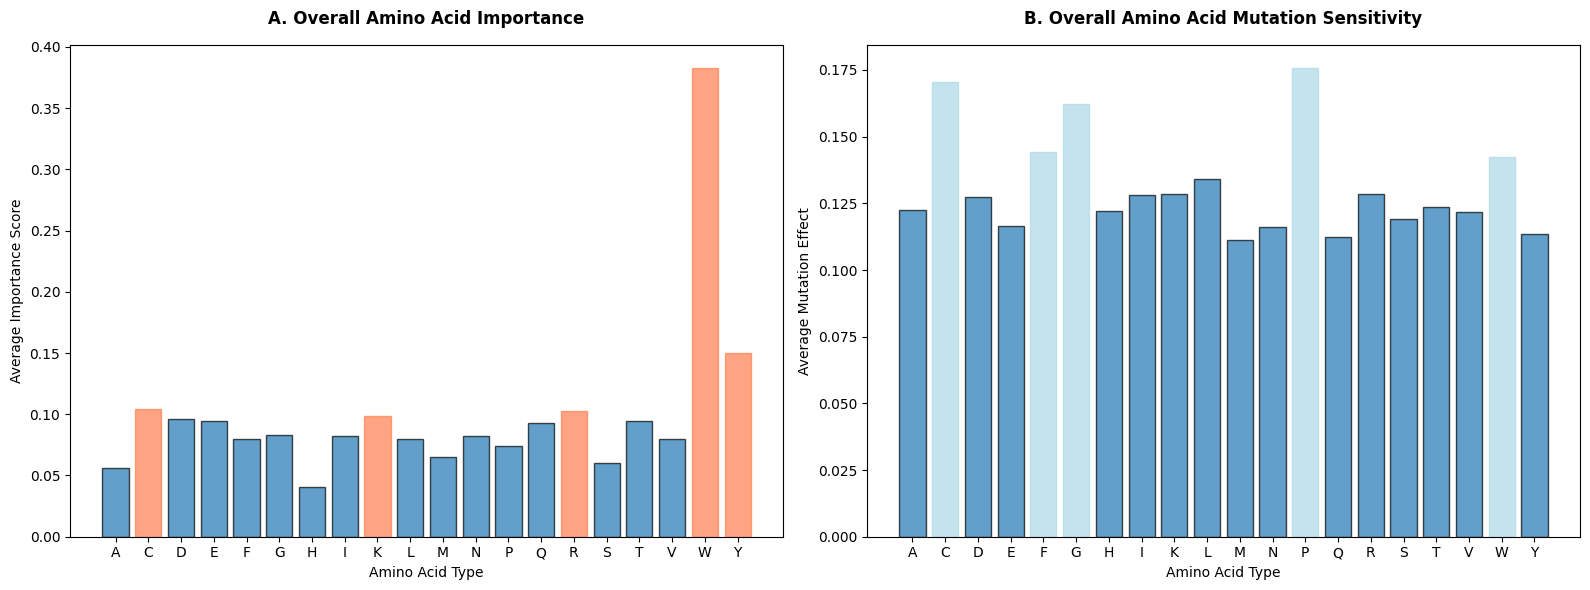

In [14]:
# ==========================================
# Cell 6: Targeted Interpretability Analysis for EPOP Framework
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
import random
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.auto import tqdm

# Configuration
PROJECT_ROOT = '/content/drive/MyDrive/protein_classification'
MODELS_DIR = f'{PROJECT_ROOT}/models'
DATA_DIR = f'{PROJECT_ROOT}/final_analysis'
OUTPUT_DIR = f'{PROJECT_ROOT}/interpretability_plots'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Target proteins for analysis
TARGET_PROTEINS = ['Q99715', 'Q06828', 'Q05707', 'P22105', 'P12111', 'P12109',
                  'P08123', 'Q15582', 'P02751', 'P02458', 'P24821', 'P04004',
                  'Q12805', 'P08572', 'P98160', 'P05997']

amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# Load model (reuse from previous code)
def load_esm_model():
    """Load fine-tuned ESM-2 model for ECM prediction"""
    model_path = f"{MODELS_DIR}/esm2_ecm_model_enhanced"

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model not found at {model_path}")

    print(f"Loading model from: {model_path}")
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    print(f"Model loaded successfully on {device}")
    return model, tokenizer

# Create predict_functions equivalent
def predict_functions(sequence):
    """Predict ECM probability - equivalent to original predict_functions"""
    if not isinstance(sequence, str) or not sequence.strip():
        return 0.0

    try:
        device = next(model.parameters()).device
        inputs = tokenizer(
            sequence,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=1024
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        probs = torch.softmax(outputs.logits, dim=-1)
        return probs[0][1].cpu().item()

    except Exception:
        return 0.0

def analyze_single_aa_importance(sequence, model_predict_func, mask_token='<mask>'):
    """Analyze importance of each amino acid by masking"""
    original_prediction = model_predict_func(sequence)
    importance_scores = []

    for i in range(len(sequence)):
        masked_sequence = sequence[:i] + mask_token + sequence[i+1:]
        masked_prediction = model_predict_func(masked_sequence)
        importance_score = abs(original_prediction - masked_prediction)
        importance_scores.append(importance_score)

    return importance_scores

def analyze_sequence_variants(sequence, model_predict_func):
    """Analyze effects of sequence variants by testing all amino acid substitutions"""
    original_prediction = model_predict_func(sequence)
    mutation_effects = {}

    for i in range(len(sequence)):
        for new_aa in amino_acids:
            if new_aa != sequence[i]:  # Skip if same as original
                mutated_sequence = sequence[:i] + new_aa + sequence[i+1:]
                mutated_prediction = model_predict_func(mutated_sequence)
                effect_score = abs(original_prediction - mutated_prediction)
                mutation_effects[(i, new_aa)] = effect_score

    return mutation_effects

def identify_functional_regions(sequence, model_predict_func, window_size=10, step_size=1):
    """Identify functional regions using sliding window"""
    region_scores = []

    for i in range(0, len(sequence) - window_size + 1, step_size):
        subsequence = sequence[i:i+window_size]
        subsequence_prediction = model_predict_func(subsequence)
        region_scores.append(subsequence_prediction)

    return region_scores

def interpret_sequence(sequence, model_predict_func):
    """Complete interpretability analysis for a sequence"""
    aa_importance_scores = analyze_single_aa_importance(sequence, model_predict_func)
    mutation_effects = analyze_sequence_variants(sequence, model_predict_func)
    region_scores = identify_functional_regions(sequence, model_predict_func, window_size=10, step_size=1)
    return aa_importance_scores, mutation_effects, region_scores

def generate_text_analysis_report(protein_id, gene_name, sequence, aa_importance_scores, mutation_effects, region_scores, esm_score):
    """Generate detailed text analysis report"""

    report = f"""
=== INTERPRETABILITY ANALYSIS REPORT ===
Protein ID: {protein_id}
Gene Name: {gene_name}
ESM Score: {esm_score:.4f}
Sequence Length: {len(sequence)}
Sequence: {sequence}

1. AMINO ACID IMPORTANCE ANALYSIS
{'='*50}
Top 5 Most Important Positions:
"""

    # Find top important positions
    top_positions = sorted(enumerate(aa_importance_scores), key=lambda x: x[1], reverse=True)[:5]
    for rank, (pos, score) in enumerate(top_positions, 1):
        aa = sequence[pos]
        report += f"  {rank}. Position {pos+1}: {aa} (Importance: {score:.4f})\n"

    report += f"\nAverage importance score: {np.mean(aa_importance_scores):.4f}\n"
    report += f"Standard deviation: {np.std(aa_importance_scores):.4f}\n"

    # Mutation effects analysis
    report += f"""
2. MUTATION EFFECTS ANALYSIS
{'='*50}
Top 5 Most Sensitive Mutations:
"""

    top_mutations = sorted(mutation_effects.items(), key=lambda x: x[1], reverse=True)[:5]
    for rank, ((pos, new_aa), effect) in enumerate(top_mutations, 1):
        original_aa = sequence[pos]
        report += f"  {rank}. Position {pos+1}: {original_aa}→{new_aa} (Effect: {effect:.4f})\n"

    # Functional regions analysis
    report += f"""
3. FUNCTIONAL REGIONS ANALYSIS
{'='*50}
Top 3 Highest Scoring Regions (10-AA windows):
"""

    if region_scores:
        top_regions = sorted(enumerate(region_scores), key=lambda x: x[1], reverse=True)[:3]
        for rank, (start_pos, score) in enumerate(top_regions, 1):
            end_pos = start_pos + 10
            region_seq = sequence[start_pos:end_pos]
            report += f"  {rank}. Positions {start_pos+1}-{end_pos}: {region_seq} (Score: {score:.4f})\n"

        report += f"\nAverage region score: {np.mean(region_scores):.4f}\n"
        report += f"Maximum region score: {max(region_scores):.4f}\n"
        report += f"Minimum region score: {min(region_scores):.4f}\n"

    # Summary insights
    report += f"""
4. SUMMARY INSIGHTS
{'='*50}
- Sequence shows {'high' if esm_score > 0.8 else 'moderate' if esm_score > 0.5 else 'low'} ECM prediction confidence
- Most critical amino acid: {sequence[top_positions[0][0]]} at position {top_positions[0][0]+1}
- Highest mutation sensitivity: {original_aa}→{new_aa} at position {top_mutations[0][0][0]+1}
- Most functional region: positions {top_regions[0][0]+1}-{top_regions[0][0]+10} if region_scores else "N/A"

"""

    return report

def run_targeted_interpretability_analysis():
    """Run interpretability analysis on target proteins only"""

    # Load final protein data
    if 'final_protein_df' not in globals():
        try:
            final_protein_path = os.path.join(PROJECT_ROOT, "final_analysis", "final_unique_protein_table.csv")
            if os.path.exists(final_protein_path):
                print("Loading final_protein_df from saved file...")
                global final_protein_df
                final_protein_df = pd.read_csv(final_protein_path)
                print(f"Loaded {len(final_protein_df)} proteins")
            else:
                print("Error: final_protein_df not found")
                return
        except Exception as e:
            print(f"Error loading data: {e}")
            return

    # Load enhanced_data for sequences
    if 'enhanced_data' not in globals():
        print("Warning: enhanced_data not found. Using final_protein_df only.")
        enhanced_data = final_protein_df

    print("=== Targeted ESM-2 ECM Prediction Interpretability Analysis ===")
    print(f"Analyzing {len(TARGET_PROTEINS)} specific literature-validated proteins")

    # Load model
    global model, tokenizer
    try:
        model, tokenizer = load_esm_model()
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return

    # Filter for target proteins
    target_data = final_protein_df[final_protein_df['UniProt_ID'].isin(TARGET_PROTEINS)].copy()

    if len(target_data) == 0:
        print("No target proteins found in the dataset")
        return

    print(f"Found {len(target_data)} target proteins in dataset")

    # Initialize comprehensive report and aggregation data
    comprehensive_report = f"""
COMPREHENSIVE INTERPRETABILITY ANALYSIS REPORT
Literature-Validated ECM Proteins Analysis
{'='*80}
Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
Total Proteins Analyzed: {len(target_data)}
Target Protein List: {', '.join(TARGET_PROTEINS)}

{'='*80}
"""

    # Initialize aggregation dictionaries
    all_aa_importance = {aa: [] for aa in amino_acids}
    all_mutation_effects = {aa: [] for aa in amino_acids}
    analyzed_proteins = []

    # Process each target protein
    for idx, (_, row) in enumerate(target_data.iterrows(), 1):
        protein_id = row['UniProt_ID']
        gene_name = row.get('Gene_Name', 'N/A')
        esm_score = row.get('Top_ESM_Score', 0.0)

        print(f"\nProcessing {idx}/{len(target_data)}: {protein_id} ({gene_name})")

        # Get sequence from enhanced_data if available
        if 'enhanced_data' in globals():
            protein_sequences = enhanced_data[enhanced_data['UniProt_ID'] == protein_id]
            if len(protein_sequences) > 0:
                # Use the sequence with highest ESM score for this protein
                best_sequence = protein_sequences.loc[protein_sequences['esm_result'].idxmax(), 'Peptide']
            else:
                print(f"  No sequences found for {protein_id}")
                continue
        else:
            # Try to get sequence from peptide list if available
            if 'Peptide_List' in row and pd.notna(row['Peptide_List']):
                peptides = row['Peptide_List'].split('; ')
                best_sequence = max(peptides, key=len)  # Use longest peptide
            else:
                print(f"  No sequence data available for {protein_id}")
                continue

        if not isinstance(best_sequence, str) or len(best_sequence) < 5:
            print(f"  Invalid sequence for {protein_id}")
            continue

        print(f"  Analyzing sequence: {best_sequence[:50]}{'...' if len(best_sequence) > 50 else ''}")

        # Run interpretability analysis
        try:
            aa_importance_scores, mutation_effects, region_scores = interpret_sequence(best_sequence, predict_functions)

            # Collect data for aggregation
            for i, aa in enumerate(best_sequence):
                if i < len(aa_importance_scores):
                    all_aa_importance[aa].append(aa_importance_scores[i])

            # Collect mutation effects by amino acid type
            for (pos, new_aa), effect in mutation_effects.items():
                all_mutation_effects[new_aa].append(effect)

            analyzed_proteins.append({
                'protein_id': protein_id,
                'gene_name': gene_name,
                'sequence': best_sequence,
                'esm_score': esm_score
            })

            # Generate individual report
            individual_report = generate_text_analysis_report(
                protein_id, gene_name, best_sequence, aa_importance_scores,
                mutation_effects, region_scores, esm_score
            )

            # Add to comprehensive report
            comprehensive_report += individual_report + "\n" + "="*80 + "\n"

            # Create individual visualization
            fig = plt.figure(figsize=(16, 10))
            gs = fig.add_gridspec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])

            # A: AA importance plot (top left)
            ax1 = fig.add_subplot(gs[0, 0])
            ax1.plot(range(len(best_sequence)), aa_importance_scores, marker='o', linewidth=2)
            ax1.set_xticks(range(len(best_sequence)))
            ax1.set_xticklabels(list(best_sequence), rotation=90)
            ax1.set_xlabel('Amino Acid Position')
            ax1.set_ylabel('Importance Score')
            ax1.set_title(f'A. Amino Acid Importance Scores', fontweight='bold', pad=15)

            # C: Functional regions plot (bottom left)
            ax3 = fig.add_subplot(gs[1, 0])
            if region_scores:
                ax3.plot(range(len(region_scores)), region_scores, linewidth=2)
                ax3.set_xlabel('Window Start Position')
                ax3.set_ylabel('Regional ECM Score')
                ax3.set_title(f'C. Functional Region Scores', fontweight='bold', pad=15)

            # B: Mutation effects heatmap (right, spanning both rows)
            ax2 = fig.add_subplot(gs[:, 1])
            mut_scores = np.array([[mutation_effects.get((i, aa), 0) for aa in amino_acids] for i in range(len(best_sequence))])
            im = ax2.imshow(mut_scores, cmap='RdYlBu_r', aspect='auto')
            ax2.set_xticks(range(len(amino_acids)))
            ax2.set_xticklabels(amino_acids)
            ax2.set_yticks(range(len(best_sequence)))
            ax2.set_yticklabels(list(best_sequence))
            ax2.set_xlabel('Mutated Amino Acid')
            ax2.set_ylabel('Original Amino Acid Position')
            ax2.set_title(f'B. Mutation Effects Heatmap', fontweight='bold', pad=15)

            # Add colorbar for heatmap
            cbar = plt.colorbar(im, ax=ax2)
            cbar.set_label('Effect Magnitude')

            plt.tight_layout(rect=[0, 0, 1, 0.93])
            fig.suptitle(f'Interpretability Analysis - {gene_name} ({protein_id})', fontweight='bold', fontsize=16)


            safe_id = protein_id.replace('/', '_')
            plt.savefig(os.path.join(OUTPUT_DIR, f'interpretability_analysis_{safe_id}.png'),
                       dpi=300, bbox_inches='tight', facecolor='white')
            plt.close()

            print(f"  ✓ Analysis complete for {protein_id}")

        except Exception as e:
            print(f"  Error analyzing {protein_id}: {e}")
            continue

    # Generate aggregated analysis
    print(f"\n=== Generating Aggregated Analysis ===")

    # Calculate average importance and mutation effects for each amino acid
    avg_importance = {}
    avg_mutation_effects = {}

    for aa in amino_acids:
        if all_aa_importance[aa]:
            avg_importance[aa] = np.mean(all_aa_importance[aa])
        else:
            avg_importance[aa] = 0

        if all_mutation_effects[aa]:
            avg_mutation_effects[aa] = np.mean(all_mutation_effects[aa])
        else:
            avg_mutation_effects[aa] = 0

    # Create aggregated visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # A: Overall amino acid importance
    importance_values = [avg_importance[aa] for aa in amino_acids]
    bars1 = ax1.bar(amino_acids, importance_values, edgecolor='black', alpha=0.7)
    ax1.set_xlabel('Amino Acid Type')
    ax1.set_ylabel('Average Importance Score')
    ax1.set_title('A. Overall Amino Acid Importance', fontweight='bold', pad=15)
    ax1.tick_params(axis='x', rotation=0)

    # Highlight top 5 amino acids
    top_importance_indices = np.argsort(importance_values)[-5:]
    for i in top_importance_indices:
        bars1[i].set_color('coral')

    # B: Overall mutation sensitivity
    mutation_values = [avg_mutation_effects[aa] for aa in amino_acids]
    bars2 = ax2.bar(amino_acids, mutation_values, edgecolor='black', alpha=0.7)
    ax2.set_xlabel('Amino Acid Type')
    ax2.set_ylabel('Average Mutation Effect')
    ax2.set_title('B. Overall Amino Acid Mutation Sensitivity', fontweight='bold', pad=15)
    ax2.tick_params(axis='x', rotation=0)

    # Highlight top 5 amino acids
    top_mutation_indices = np.argsort(mutation_values)[-5:]
    for i in top_mutation_indices:
        bars2[i].set_color('lightblue')

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)
    plt.savefig(os.path.join(OUTPUT_DIR, 'aggregated_amino_acid_analysis.png'),
               dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    # Add aggregated analysis to report
    comprehensive_report += f"""

AGGREGATED ANALYSIS ACROSS ALL {len(analyzed_proteins)} PROTEINS
{'='*80}

1. AMINO ACID IMPORTANCE RANKING
Top 10 most important amino acids (by average importance score):
"""

    importance_ranking = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)
    for rank, (aa, score) in enumerate(importance_ranking[:10], 1):
        comprehensive_report += f"  {rank:2d}. {aa}: {score:.4f}\n"

    comprehensive_report += f"""
2. MUTATION SENSITIVITY RANKING
Top 10 most mutation-sensitive amino acids (by average effect):
"""

    mutation_ranking = sorted(avg_mutation_effects.items(), key=lambda x: x[1], reverse=True)
    for rank, (aa, score) in enumerate(mutation_ranking[:10], 1):
        comprehensive_report += f"  {rank:2d}. {aa}: {score:.4f}\n"

    comprehensive_report += f"""
3. SUMMARY STATISTICS
Total sequences analyzed: {len(analyzed_proteins)}
Average sequence length: {np.mean([len(p['sequence']) for p in analyzed_proteins]):.1f}
Average ESM score: {np.mean([p['esm_score'] for p in analyzed_proteins]):.3f}

Most important amino acid overall: {importance_ranking[0][0]} (score: {importance_ranking[0][1]:.4f})
Most mutation-sensitive amino acid: {mutation_ranking[0][0]} (effect: {mutation_ranking[0][1]:.4f})

{'='*80}
"""

    # Save comprehensive report
    report_path = os.path.join(OUTPUT_DIR, "comprehensive_interpretability_report.txt")
    with open(report_path, 'w') as f:
        f.write(comprehensive_report)


    return analyzed_proteins, avg_importance, avg_mutation_effects

# Run the analysis
analyzed_proteins, avg_importance, avg_mutation_effects = run_targeted_interpretability_analysis()

Generating combined figure for COL6A1 (P12109)...


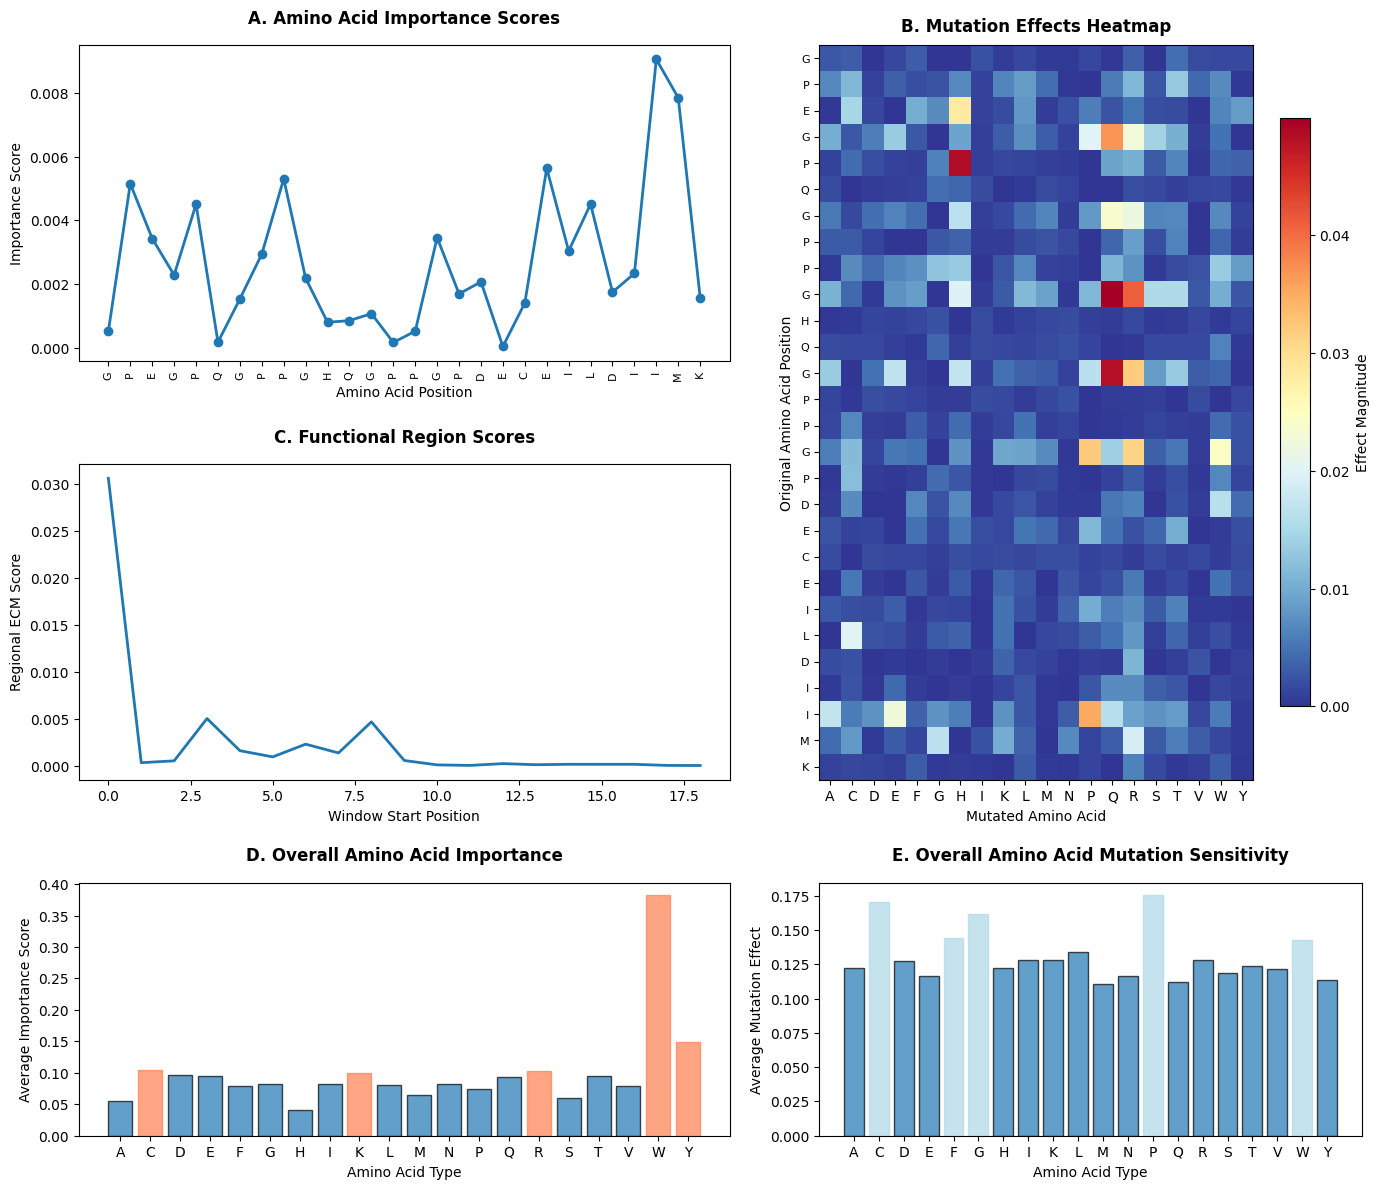

Combined figure saved in PLOS-compliant formats:
TIFF: /content/drive/MyDrive/protein_classification/final_analysis/combined_P12109_aggregated_analysis.tif
EPS: /content/drive/MyDrive/protein_classification/final_analysis/combined_P12109_aggregated_analysis.eps
PNG: /content/drive/MyDrive/protein_classification/final_analysis/combined_P12109_aggregated_analysis.png


In [27]:
# ==========================================
# Combined P12109 and Aggregated Analysis Figure
# ==========================================

def create_combined_p12109_aggregated_figure(analyzed_proteins, avg_importance, avg_mutation_effects):
    """Create combined figure with P12109 analysis (A,B,C) and aggregated analysis (D,E)"""

    # Find P12109 data
    p12109_data = None
    for protein in analyzed_proteins:
        if protein['protein_id'] == 'P12109':
            p12109_data = protein
            break

    if p12109_data is None:
        print("P12109 data not found in analyzed proteins")
        return

    # Re-run analysis for P12109 to get detailed results
    sequence = p12109_data['sequence']
    gene_name = p12109_data['gene_name']
    protein_id = p12109_data['protein_id']

    print(f"Generating combined figure for {gene_name} ({protein_id})...")

    # Run interpretability analysis for P12109
    aa_importance_scores, mutation_effects, region_scores = interpret_sequence(sequence, predict_functions)

    # Create figure with 5 subplots
    fig = plt.figure(figsize=(14, 12))
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 0.8], width_ratios=[1.2, 1])

    # A: AA importance plot (top left)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(range(len(sequence)), aa_importance_scores, marker='o', linewidth=2)
    ax1.set_xticks(range(len(sequence)))
    ax1.set_xticklabels(list(sequence), rotation=90, fontsize=8)
    ax1.set_xlabel('Amino Acid Position')
    ax1.set_ylabel('Importance Score')
    ax1.set_title('A. Amino Acid Importance Scores', fontweight='bold', pad=20, y=0.98)

    # C: Functional regions plot (middle left)
    ax3 = fig.add_subplot(gs[1, 0])
    if region_scores:
        ax3.plot(range(len(region_scores)), region_scores, linewidth=2)
        ax3.set_xlabel('Window Start Position')
        ax3.set_ylabel('Regional ECM Score')
        ax3.set_title('C. Functional Region Scores', fontweight='bold', pad=20, y=0.98)

    # B: Mutation effects heatmap (spanning right side of A and C)
    ax2 = fig.add_subplot(gs[0:2, 1])
    mut_scores = np.array([[mutation_effects.get((i, aa), 0) for aa in amino_acids] for i in range(len(sequence))])
    im = ax2.imshow(mut_scores, cmap='RdYlBu_r', aspect='auto')
    ax2.set_xticks(range(len(amino_acids)))
    ax2.set_xticklabels(amino_acids, fontsize=10)
    ax2.set_yticks(range(len(sequence)))
    ax2.set_yticklabels(list(sequence), fontsize=8)
    ax2.set_xlabel('Mutated Amino Acid')
    ax2.set_ylabel('Original Amino Acid Position')
    ax2.set_title('B. Mutation Effects Heatmap', fontweight='bold', pad=20, y=0.98)

    # Add colorbar for heatmap
    cbar = plt.colorbar(im, ax=ax2, shrink=0.8)
    cbar.set_label('Effect Magnitude')

    # D: Overall amino acid importance (bottom left)
    ax4 = fig.add_subplot(gs[2, 0])
    importance_values = [avg_importance[aa] for aa in amino_acids]
    bars1 = ax4.bar(amino_acids, importance_values, edgecolor='black', alpha=0.7)
    ax4.set_xlabel('Amino Acid Type')
    ax4.set_ylabel('Average Importance Score')
    ax4.set_title('D. Overall Amino Acid Importance', fontweight='bold', pad=20, y=0.98)
    ax4.tick_params(axis='x', rotation=0)

    # Highlight top 5 amino acids
    top_importance_indices = np.argsort(importance_values)[-5:]
    for i in top_importance_indices:
        bars1[i].set_color('coral')

    # E: Overall mutation sensitivity (bottom right)
    ax5 = fig.add_subplot(gs[2, 1])
    mutation_values = [avg_mutation_effects[aa] for aa in amino_acids]
    bars2 = ax5.bar(amino_acids, mutation_values, edgecolor='black', alpha=0.7)
    ax5.set_xlabel('Amino Acid Type')
    ax5.set_ylabel('Average Mutation Effect')
    ax5.set_title('E. Overall Amino Acid Mutation Sensitivity', fontweight='bold', pad=20, y=0.98)
    ax5.tick_params(axis='x', rotation=0)

    # Highlight top 5 amino acids
    top_mutation_indices = np.argsort(mutation_values)[-5:]
    for i in top_mutation_indices:
        bars2[i].set_color('lightblue')

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.35, wspace=0.15)

    # Save in PLOS-compliant formats
    base_path = os.path.join(OUTPUT_DIR, 'combined_P12109_aggregated_analysis')

    # TIFF with LZW compression
    plt.savefig(f'{base_path}.tif', dpi=300, bbox_inches='tight', facecolor='white',
                format='tiff', pil_kwargs={'compression': 'tiff_lzw'})

    # EPS format
    plt.savefig(f'{base_path}.eps', dpi=300, bbox_inches='tight', facecolor='white')

    # PNG for preview
    plt.savefig(f'{base_path}.png', dpi=300, bbox_inches='tight', facecolor='white')

    plt.show()

    print(f"Combined figure saved in PLOS-compliant formats:")
    print(f"TIFF: {base_path}.tif")
    print(f"EPS: {base_path}.eps")
    print(f"PNG: {base_path}.png")

    return fig

# Run the function to create combined figure
if 'analyzed_proteins' in locals() and 'avg_importance' in locals() and 'avg_mutation_effects' in locals():
    combined_fig = create_combined_p12109_aggregated_figure(analyzed_proteins, avg_importance, avg_mutation_effects)
else:
    print("Please run the main interpretability analysis first to generate the required data.")